In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install torchmetrics
!pip install SciencePlots

# Standard library imports
import os
import datetime
from itertools import cycle
from typing import List, Tuple, Union

# Third-party imports for array manipulation, data processing, and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import networkx as nx

# PyTorch core and neural network imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# PyTorch Geometric imports for graph neural networks
import torch_geometric.transforms as T
from torch_geometric.nn import GATv2Conv, to_hetero, GraphConv, SAGEConv, SplineConv, GATConv
from torch_geometric.data import Data, HeteroData
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.utils import negative_sampling

# Scikit-learn imports for metrics
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, f1_score

# Conditional installation for PyTorch Geometric, only if not in a specific environment
if 'IS_GRADESCOPE_ENV' not in os.environ:
    torch_version = str(torch.__version__)
    scatter_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
    sparse_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
    !pip install torch-scatter -f $scatter_src
    !pip install torch-sparse -f $sparse_src
    !pip install torch-geometric
    !pip install ogb

# Additional library for advanced plotting
import scienceplots # Assumes SciencePlots is successfully installed via pip

# Set matplotlib style for scientific plotting
plt.style.use(['science', 'no-latex'])

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

### NN classes

In [ ]:
class GNNEncoder(nn.Module):
  def __init__(
      self,
      num_blocks: int = 1,
      activation:nn = nn.ReLU,
      RGNN:nn = GATv2Conv,
      hidden_layer:int = 512,
      heads:int = 4,
      attetion_based: bool = False,
      dropout:float = 0.2
    ):

    """
    Encodes node features using multiple graph neural network blocks.

    This class constructs a multi-layer graph neural network (GNN) encoder, where each layer consists of a GNN layer
    followed by batch normalization and an activation function. It supports various GNN architectures and activations.

    **Parameters:**

    - num_blocks (int, optional): The number of GNN blocks to stack. Defaults to 1.
    - activation (nn.Module, optional): The activation function to apply after each block. Defaults to nn.PReLU.
    - RGNN (nn.Module, optional): The type of GNN layer to use. Defaults to GATv2Conv.
    - hidden_layer (int, optional): The dimensionality of the hidden layer in each GNN block. Defaults to 64.
    - heads (int, optional): The number of attention heads for GAT-based GNN layers. Defaults to 4.
    - dropout (float, optional): The dropout probability for regularization. Defaults to 0.2.

    **Returns:**

    - torch.Tensor: The encoded node features, with shape (num_nodes, hidden_layer * heads).
    """

    super().__init__()

    self.num_blocks = num_blocks
    self.gnn_layers = nn.ModuleList()
    self.norm_layers = nn.ModuleList()
    self.activation = activation()
    self.dropout = nn.Dropout(dropout)
    self.attetion_based = attetion_based
    print(self.attetion_based)
    for _ in range(self.num_blocks):
      if self.attetion_based:
        self.gnn_layers.append(RGNN((-1, -1),hidden_layer,heads = heads, add_self_loops = False))
        self.norm_layers.append(nn.BatchNorm1d(hidden_layer*heads))
      else:
        self.gnn_layers.append(RGNN((-1, -1),hidden_layer))
        self.norm_layers.append(nn.BatchNorm1d(hidden_layer))
      #self.gnn_layers.append(SAGEConv((-1, -1), out_channels=3072))

  def forward(self, nodes_features, edge_index):

    for gnn,norm in zip(self.gnn_layers,self.norm_layers):
      nodes_features = gnn(nodes_features,edge_index)
      nodes_features = norm(nodes_features)
      nodes_features = self.activation(nodes_features)
      nodes_features = self.dropout(nodes_features)
    return nodes_features



In [ ]:
class GNN(nn.Module):
  def __init__(
        self,
        data_sample,
        num_blocks: int = 2,
        activation:nn = nn.ReLU,
        RGNN:nn = GATv2Conv,
        dropout:float = 0.1,
        hidden_layer:int = 512,
        heads:int = 12,
        num_hidden_layers: int = 3
    ):

    """
    Constructs a graph neural network for link prediction in heterogeneous graphs.

    This class combines a multi-layer GNN encoder for node feature learning with a feedforward network
    to predict link existence scores. It's designed for heterogeneous graphs where nodes have different types.

    **Parameters:**

    - data_sample (PyG Data object): A sample of the heterogeneous graph data used for metadata extraction.
    - num_blocks (int, optional): The number of GNN blocks in the encoder. Defaults to 2.
    - activation (nn.Module, optional): The activation function used in GNN blocks and feedforward layers. Defaults to nn.PReLU.
    - RGNN (nn.Module, optional): The type of GNN layer to use. Defaults to GATv2Conv.
    - dropout (float, optional): The dropout probability for regularization. Defaults to 0.2.
    - hidden_layer (int, optional): The dimensionality of the hidden layer in GNN blocks. Defaults to 64.
    - heads (int, optional): The number of attention heads for GAT-based GNN layers. Defaults to 4.
    - num_hidden_layers (int, optional): The number of hidden layers in the feedforward network. Defaults to 3.
    """

    super().__init__()

    self.encoder = GNNEncoder(num_blocks, activation, RGNN, hidden_layer, heads, dropout)
    self.encoder = to_hetero(self.encoder, data_sample.metadata(), aggr='mean')

    self.feedforward = nn.ModuleList()
    self.final_activation_function = nn.Sigmoid()
    self.feedforward_input_size = 2*hidden_layer*heads
    self.feedforward_hidden_size = 2*self.feedforward_input_size
    # add input layer
    self.feedforward.append(nn.Linear(self.feedforward_input_size,self.feedforward_hidden_size))
    self.feedforward.append(activation())
    self.feedforward.append(nn.Dropout(dropout))

    # add hidden layers
    for _ in range(num_hidden_layers):
      self.feedforward.append(nn.Linear(self.feedforward_hidden_size, self.feedforward_hidden_size))
      self.feedforward.append(activation())
      self.feedforward.append(nn.Dropout(dropout))

    # add output layer
    self.feedforward.append(nn.Linear(self.feedforward_hidden_size,1))
    self.feedforward.append(self.final_activation_function)

  def forward(self, nodes_features, edge_index, edge_label_index):
    nodes_embs = self.encoder(nodes_features, edge_index)
    print(nodes_embs['gene'].size())
    gene_embs = nodes_embs['gene'][edge_label_index[1]]
    disease_embs = nodes_embs['disease'][edge_label_index[0]]
    concat = torch.cat((gene_embs,disease_embs), dim=1)
    for layer in self.feedforward:
      concat = layer(concat)
    return concat.view(-1)


In [ ]:
class GNN_dot_product(nn.Module):
  """
  Constructs a graph neural network for link prediction in heterogeneous graphs using a dot product approach.

  This class combines a multi-layer GNN encoder for node feature learning with a dot product operation
  to predict link existence scores. It's designed for heterogeneous graphs where nodes have different types.

  **Parameters:**

  - data_sample (PyG Data object): A sample of the heterogeneous graph data used for metadata extraction.
  - num_blocks (int, optional): The number of GNN blocks in the encoder. Defaults to 2.
  - activation (nn.Module, optional): The activation function used in GNN blocks (defaults to nn.ReLU).
  - RGNN (nn.Module, optional): The type of GNN layer to use (defaults to GATv2Conv).
  - dropout (float, optional): The dropout probability for regularization (defaults to 0.1).
  - hidden_layer (int, optional): The dimensionality of the hidden layer in GNN blocks (defaults to 512).
  - heads (int, optional): The number of attention heads for GAT-based GNN layers (defaults to 12).
  """

  def __init__(self, data_sample, num_blocks=1, activation=nn.ReLU, RGNN=GATv2Conv, dropout=0.2, hidden_layer=256, heads=8, attetion_based: bool = False):
    super().__init__()

    self.encoder = GNNEncoder(num_blocks = num_blocks, activation = activation, RGNN = RGNN, hidden_layer = hidden_layer, heads = heads, attetion_based = attetion_based,dropout = dropout)
    self.encoder = to_hetero(self.encoder, data_sample.metadata(), aggr='mean')

  def forward(self, nodes_features, edge_index, edge_label_index):

    nodes_embs = self.encoder(nodes_features, edge_index)

    gene_embs = nodes_embs['gene'][edge_label_index[1]]
    disease_embs = nodes_embs['disease'][edge_label_index[0]]

    # Dot product for link prediction
    scores = torch.sum(gene_embs * disease_embs, dim=1)  # Element-wise multiplication and summation

    return scores


### Data

In [ ]:
encoded_genes_tensors = torch.tensor(np.load("/content/drive/MyDrive/Projetos/GNN-Gene-Disease/Data/embeddings/posisions_encoded.npy")).to(torch.float32)
encoded_diseases_tensors = torch.load("/content/drive/MyDrive/Projetos/GNN-Gene-Disease/Data/embeddings/disease_df_encoded.pt").to(torch.float32)
connection_disease_gene = torch.load("/content/drive/MyDrive/Projetos/GNN-Gene-Disease/Data/edges/connection_disease_gene_augmented.pt")

In [ ]:
reshaped_encoded_diseases_tensors = encoded_diseases_tensors.view(encoded_diseases_tensors.size()[0], -1)
reshaped_encoded_genes_tensors = encoded_genes_tensors.view(encoded_genes_tensors.size()[0], -1)

#### Creating graph

In [ ]:
# Create a HeteroData object
data_sample = HeteroData()

data_sample['gene'].node_id = torch.arange(reshaped_encoded_genes_tensors.size()[0])
data_sample['disease'].node_id = torch.arange(reshaped_encoded_diseases_tensors.size()[0])

# Add node features for diseases
data_sample['disease'].x = reshaped_encoded_diseases_tensors

# Add node features for genes
data_sample['gene'].x = reshaped_encoded_genes_tensors

data_sample['disease', 'actuates', 'gene'].edge_index = connection_disease_gene

data_sample = T.ToUndirected()(data_sample)

In [ ]:
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.1, num_test=0.1, is_undirected=True,
                      add_negative_train_samples=True,neg_sampling_ratio = 1, edge_types = ('disease', 'actuates', 'gene')),
])

In [ ]:
train_data, val_data, test_data = transform(data_sample)

### Train

In [ ]:
def train_final_model(
    model: nn.Module,
    total_training_loader: DataLoader,
    total_test_loader: DataLoader,
    n_epochs: int,
    optimizer: optim.Optimizer,
    scheduler: optim.lr_scheduler,
    criterion: nn.Module,
    device: Union[torch.device, str],
    model_save_path: str,
    save_interval: int = 10
    )-> Tuple[List[float], List[float], List[float], List[float]]:

    """

    Trains a PyTorch model.

    Args:

    - model (nn.Module): the PyTorch model to be trained
    - train_loader (DataLoader): DataLoader containing the training set
    - test_loader (DataLoader): DataLoader containing the test set
    - n_epochs (int): number of training epochs
    - optimizer (optim.Optimizer): the optimizer to use for training
    - scheduler (optim.lr_scheduler): the sheduler used for training
    - criterion (nn.Module): the loss function to use for training
    - device (str): device to run the model on (e.g. 'cpu' or 'cuda')
    - model_save_path (str): path to the folder where the model will be saved
    - save_interval (int): save the model every save_interval epochs

    Returns:

    - mean_loss_train (list) : mean loss per epoch for the training set
    - mean_f1_train (list) : mean f1 score per epoch for the training set
    - mean_loss_test (list) : mean loss per epoch for the test set
    - mean_f1_test (list) : mean f1 score per epoch for the test set


    """

    # initialize lists to keep track of metrics
    mean_loss_train = []
    mean_f1_train = []
    mean_acc_train = []
    mean_auc_train = []

    mean_loss_test = []
    mean_f1_test = []
    mean_acc_test = []
    mean_auc_test = []

    # loop over epochs
    for it in range(1, n_epochs+1):

        # initialize list to keep track of train loss for this epoch
        train_loss = []
        train_f1 = []
        train_acc = []
        train_auc = []

        # set model to train mode
        model.train()

        cont = 0

        # loop over training data
        for sampled_data in total_training_loader:

            # zero the gradients
            optimizer.zero_grad()

            # to device
            sampled_data.to(device)

            # getting outputs from model
            outputs = model(sampled_data.x_dict, sampled_data.edge_index_dict, sampled_data['disease', 'actuates', 'gene'].edge_label_index)

            #getting real edges from graph
            targets = sampled_data['disease', 'actuates', 'gene'].edge_label

            # compute loss
            loss = criterion(outputs, targets)

            # backward pass and optimization step
            loss.backward()
            optimizer.step()

            # append loss to train_loss list
            train_loss.append(loss.item())

            # F1 Score
            preds = outputs.detach().cpu().numpy().flatten()
            labels = targets.detach().cpu().numpy().flatten()


            preds = [1 if pred>0.5 else 0 for pred in preds]
            train_f1.append(f1_score(labels,preds))
            train_acc.append(accuracy_score(labels,preds))
            train_auc.append(roc_auc_score(labels,preds))

        # initialize list to keep track of test loss for this epoch
        test_loss = []
        test_f1 = []
        test_acc = []
        test_auc = []


        # set model to train mode
        model.eval()

        # turn off gradients for evaluation
        with torch.no_grad():

          # loop over test data
          for sampled_data in total_test_loader:

              # to device
              sampled_data.to(device)

              # getting outputs from model
              outputs = model(sampled_data.x_dict, sampled_data.edge_index_dict, sampled_data['disease', 'actuates', 'gene'].edge_label_index)

              # getting real edges from graph
              targets = sampled_data['disease', 'actuates', 'gene'].edge_label

              # compute loss
              loss = criterion(outputs, targets)

              # append loss to train_loss list
              test_loss.append(loss.item())

              # F1 Score
              preds = outputs.detach().cpu().numpy().flatten()
              labels = targets.detach().cpu().numpy().flatten()

              preds = [1 if pred>0.5 else 0 for pred in preds]
              test_f1.append(f1_score(labels,preds))
              test_acc.append(accuracy_score(labels,preds))
              test_auc.append(roc_auc_score(labels,preds))


        # Step the scheduler
        scheduler.step(loss)
        lr = optimizer.param_groups[0]['lr']

        # append the mean train loss for this epoch to the list of train losses
        mean_loss_train.append(np.mean(train_loss))
        mean_f1_train.append(np.mean(train_f1))
        mean_acc_train.append(np.mean(train_acc))
        mean_auc_train.append(np.mean(train_auc))
        mean_loss_test.append(np.mean(test_loss))
        mean_f1_test.append(np.mean(test_f1))
        mean_acc_test.append(np.mean(test_acc))
        mean_auc_test.append(np.mean(test_auc))


        # print epoch metrics
        print(f'Epoch {it}/{n_epochs}, Train Loss: {mean_loss_train[-1]:.4f}, Train F1: {mean_f1_train[-1]:.4f},Val Loss: {mean_loss_test[-1]:.4f}, Val F1: {mean_f1_test[-1]:.4f}, lr: {lr}')

        # Saving the model at each 10 epochs
        #if it%save_interval==0 and it!=0:
          #torch.save(model.state_dict(), os.path.join(model_save_path,f'GNN_epoch_{it}f1test{mean_f1_test[-1]:.4f}date{datetime.datetime.now().strftime("%d%m%Y-%H%M%S")}.pth'))

    results = {
      'mean_loss_train': mean_loss_train,
      'mean_f1_train': mean_f1_train,
      'mean_acc_train': mean_acc_train,
      'mean_auc_train': mean_auc_train,
      'mean_loss_test': mean_loss_test,
      'mean_f1_test': mean_f1_test,
      'mean_acc_test': mean_acc_test,
      'mean_auc_test': mean_auc_test

    }
    # return lists of mean train
    return results

#### Defining loaders

In [ ]:
# Define seed edges:
edge_label_index = train_data['disease', 'actuates', 'gene'].edge_label_index
edge_label = train_data['disease', 'actuates', 'gene'].edge_label

train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[8221, 8221],
    edge_label_index=(('disease', 'actuates', 'gene'), edge_label_index),
    edge_label=edge_label,
    batch_size=8221,
    shuffle=True,
)
sampled_data = next(iter(train_loader))

/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [ ]:
# Define the validation seed edges:
edge_label_index = val_data['disease', 'actuates', 'gene'].edge_label_index
edge_label = val_data['disease', 'actuates', 'gene'].edge_label

val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[-1, -1],
    edge_label_index=(('disease', 'actuates', 'gene'), edge_label_index),
    edge_label=edge_label,
    batch_size=8221,
    shuffle=True,
)
sampled_data = next(iter(val_loader))

In [ ]:
# Define the validation seed edges:
edge_label_index = test_data['disease', 'actuates', 'gene'].edge_label_index
edge_label = test_data['disease', 'actuates', 'gene'].edge_label

test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=[-1, -1],
    edge_label_index=(('disease', 'actuates', 'gene'), edge_label_index),
    edge_label=edge_label,
    batch_size=8221,
    shuffle=True,
)
sampled_data = next(iter(val_loader))

### Training


In [ ]:
model = GNN(data_sample,num_blocks=1,num_hidden_layers=4,dropout = 0.2,hidden_layer=256,heads=6,activation = nn.ELU)#to_hetero(gnn.to(device), data_sample.metadata(), aggr='sum')
model.to(device)

0.2


GNN(
  (encoder): GraphModule(
    (gnn_layers): ModuleList(
      (0): ModuleDict(
        (disease__actuates__gene): GATv2Conv((-1, -1), 256, heads=6)
        (gene__rev_actuates__disease): GATv2Conv((-1, -1), 256, heads=6)
      )
    )
    (norm_layers): ModuleList(
      (0): ModuleDict(
        (gene): BatchNorm1d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (disease): BatchNorm1d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (activation): ModuleDict(
      (gene): ELU(alpha=1.0)
      (disease): ELU(alpha=1.0)
    )
    (dropout): ModuleDict(
      (gene): Dropout(p=0.2, inplace=False)
      (disease): Dropout(p=0.2, inplace=False)
    )
  )
  (feedforward): ModuleList(
    (0): Linear(in_features=3072, out_features=6144, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=6144, out_features=6144, bias=True)
    (4): ELU(alpha=1.0)
    (5): Dropout(p=0.2, 

In [ ]:
model_save_path = "/content/drive/MyDrive/Projetos/GNN-Gene-Disease/models/GATv2Conv"
num_epochs = 500
save_interval = 5

In [ ]:
model_dot = GNN_dot_product(data_sample,num_blocks=1,dropout = 0.2,hidden_layer=64,heads=4,activation = nn.ELU, attetion_based = True)#to_hetero(gnn.to(device), data_sample.metadata(), aggr='sum')
model_dot.to(device)

optimizer = torch.optim.Adam(params=model_dot.parameters(), lr=1e-1,weight_decay = 1e-3)
criterion = F.binary_cross_entropy_with_logits
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=False)

results_gatv2 = train_final_model(
    model_dot,
    total_training_loader = train_loader,
    total_test_loader = val_loader,
    n_epochs = num_epochs,
    optimizer = optimizer,
    scheduler = scheduler,
    criterion = criterion,
    device = device,
    model_save_path = model_save_path,
    save_interval = save_interval)

True
Epoch 1/500, Train Loss: 6.7932, Train F1: 0.4319,Val Loss: 0.9802, Val F1: 0.6706, lr: 0.1
Epoch 2/500, Train Loss: 6.1588, Train F1: 0.6965,Val Loss: 1.8402, Val F1: 0.5929, lr: 0.1
Epoch 3/500, Train Loss: 4.3279, Train F1: 0.7783,Val Loss: 1.9532, Val F1: 0.5970, lr: 0.1
Epoch 4/500, Train Loss: 2.5558, Train F1: 0.7902,Val Loss: 1.6436, Val F1: 0.1683, lr: 0.1
Epoch 5/500, Train Loss: 2.1092, Train F1: 0.5074,Val Loss: 2.0460, Val F1: 0.0416, lr: 0.1
Epoch 6/500, Train Loss: 1.3325, Train F1: 0.4914,Val Loss: 1.3026, Val F1: 0.5952, lr: 0.1
Epoch 7/500, Train Loss: 1.2372, Train F1: 0.7589,Val Loss: 1.5604, Val F1: 0.6085, lr: 0.1
Epoch 8/500, Train Loss: 1.2284, Train F1: 0.7660,Val Loss: 1.3783, Val F1: 0.6049, lr: 0.1
Epoch 9/500, Train Loss: 0.9262, Train F1: 0.6952,Val Loss: 1.3579, Val F1: 0.5773, lr: 0.1
Epoch 10/500, Train Loss: 0.8793, Train F1: 0.5941,Val Loss: 1.5520, Val F1: 0.6074, lr: 0.1
Epoch 11/500, Train Loss: 0.7568, Train F1: 0.7349,Val Loss: 1.9457, Val F

KeyboardInterrupt: 

In [ ]:
model_dot = GNN_dot_product(data_sample,num_blocks=1,dropout = 0.2,hidden_layer=64,activation = nn.ELU,RGNN=GraphConv, attetion_based = False)#to_hetero(gnn.to(device), data_sample.metadata(), aggr='sum')
model_dot.to(device)

optimizer = torch.optim.Adam(params=model_dot.parameters(), lr=1e-1,weight_decay = 1e-3)
criterion = F.binary_cross_entropy_with_logits
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=False)

results_GraphConv = train_final_model(
    model_dot,
    total_training_loader = train_loader,
    total_test_loader = val_loader,
    n_epochs = num_epochs,
    optimizer = optimizer,
    scheduler = scheduler,
    criterion = criterion,
    device = device,
    model_save_path = model_save_path,
    save_interval = save_interval)

False
Epoch 1/500, Train Loss: 2.4601, Train F1: 0.5075,Val Loss: 2.8351, Val F1: 0.4328, lr: 0.1
Epoch 2/500, Train Loss: 1.1169, Train F1: 0.7587,Val Loss: 3.7758, Val F1: 0.6691, lr: 0.1
Epoch 3/500, Train Loss: 1.2929, Train F1: 0.7941,Val Loss: 3.4429, Val F1: 0.6770, lr: 0.1
Epoch 4/500, Train Loss: 1.2190, Train F1: 0.7886,Val Loss: 2.3617, Val F1: 0.6734, lr: 0.1
Epoch 5/500, Train Loss: 0.9836, Train F1: 0.7766,Val Loss: 1.5394, Val F1: 0.6850, lr: 0.1
Epoch 6/500, Train Loss: 0.7887, Train F1: 0.7270,Val Loss: 1.0596, Val F1: 0.6276, lr: 0.1
Epoch 7/500, Train Loss: 0.8394, Train F1: 0.6234,Val Loss: 0.7472, Val F1: 0.5868, lr: 0.1
Epoch 8/500, Train Loss: 0.7369, Train F1: 0.5917,Val Loss: 0.6144, Val F1: 0.6974, lr: 0.1
Epoch 9/500, Train Loss: 0.5683, Train F1: 0.6905,Val Loss: 0.5970, Val F1: 0.7006, lr: 0.1
Epoch 10/500, Train Loss: 0.5296, Train F1: 0.7271,Val Loss: 0.5898, Val F1: 0.6505, lr: 0.1
Epoch 11/500, Train Loss: 0.5247, Train F1: 0.7323,Val Loss: 0.5983, Val 

In [ ]:
model_dot = GNN_dot_product(data_sample,num_blocks=1,dropout = 0.2,hidden_layer=64,activation = nn.ELU,RGNN=SAGEConv, attetion_based = False)#to_hetero(gnn.to(device), data_sample.metadata(), aggr='sum')
model_dot.to(device)

optimizer = torch.optim.Adam(params=model_dot.parameters(), lr=1e-1,weight_decay = 1e-3)
criterion = F.binary_cross_entropy_with_logits
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=False)

results_SAGEConv = train_final_model(
    model_dot,
    total_training_loader = train_loader,
    total_test_loader = val_loader,
    n_epochs = num_epochs,
    optimizer = optimizer,
    scheduler = scheduler,
    criterion = criterion,
    device = device,
    model_save_path = model_save_path,
    save_interval = save_interval)

False
Epoch 1/500, Train Loss: 1.8617, Train F1: 0.5038,Val Loss: 0.7171, Val F1: 0.1375, lr: 0.1
Epoch 2/500, Train Loss: 0.9909, Train F1: 0.5034,Val Loss: 0.8513, Val F1: 0.0000, lr: 0.1
Epoch 3/500, Train Loss: 1.0173, Train F1: 0.2389,Val Loss: 0.7181, Val F1: 0.0024, lr: 0.1
Epoch 4/500, Train Loss: 0.7828, Train F1: 0.4123,Val Loss: 0.8204, Val F1: 0.6667, lr: 0.1
Epoch 5/500, Train Loss: 0.7493, Train F1: 0.6758,Val Loss: 0.7797, Val F1: 0.6678, lr: 0.1
Epoch 6/500, Train Loss: 0.6976, Train F1: 0.5838,Val Loss: 0.6991, Val F1: 0.0000, lr: 0.1
Epoch 7/500, Train Loss: 0.6938, Train F1: 0.1078,Val Loss: 0.7405, Val F1: 0.0000, lr: 0.1
Epoch 8/500, Train Loss: 0.6933, Train F1: 0.0434,Val Loss: 0.6861, Val F1: 0.0000, lr: 0.1
Epoch 9/500, Train Loss: 0.6587, Train F1: 0.3256,Val Loss: 0.7229, Val F1: 0.6595, lr: 0.1
Epoch 10/500, Train Loss: 0.6879, Train F1: 0.6354,Val Loss: 0.7111, Val F1: 0.5478, lr: 0.1
Epoch 11/500, Train Loss: 0.6754, Train F1: 0.5436,Val Loss: 0.6827, Val 

In [ ]:
def plot_metrics_over_time(results: dict, title) -> None:
    """
    Plots mean loss, mean F1 score, mean accuracy, and mean AUC over time for both
    training and testing datasets.

    Args:
        results: A dictionary containing arrays of metric values for training and testing.

    Returns:
        None. Displays matplotlib plots.
    """
    # Determine the number of epochs or batches based on the length of the metrics
    epochs = range(len(results['mean_loss_train']))

    # Setting up the figure for a 2x2 grid of plots
    fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
    fig.suptitle(title)

    # Unpack the dictionary keys for easy access
    mean_loss_train, mean_f1_train, mean_acc_train, mean_auc_train = \
        results['mean_loss_train'], results['mean_f1_train'], results['mean_acc_train'], results['mean_auc_train']
    mean_loss_test, mean_f1_test, mean_acc_test, mean_auc_test = \
        results['mean_loss_test'], results['mean_f1_test'], results['mean_acc_test'], results['mean_auc_test']

    # Plotting each metric in its subplot
    axs[0, 0].plot(epochs, mean_loss_train, label='Train Loss')
    axs[0, 0].plot(epochs, mean_loss_test, label='Test Loss')
    axs[0, 0].set_title('Mean Loss')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()

    axs[0, 1].plot(epochs, mean_f1_train, label='Train F1')
    axs[0, 1].plot(epochs, mean_f1_test, label='Test F1')
    axs[0, 1].set_title('Mean F1 Score')
    axs[0, 1].set_ylabel('F1 Score')
    axs[0, 1].legend()

    axs[1, 0].plot(epochs, mean_acc_train, label='Train Accuracy')
    axs[1, 0].plot(epochs, mean_acc_test, label='Test Accuracy')
    axs[1, 0].set_title('Mean Accuracy')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('Accuracy')
    axs[1, 0].legend()

    axs[1, 1].plot(epochs, mean_auc_train, label='Train AUC')
    axs[1, 1].plot(epochs, mean_auc_test, label='Test AUC')
    axs[1, 1].set_title('Mean AUC')
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('AUC')
    axs[1, 1].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
def plot_accuracy_f1_over_epoch(results_dict: dict, title: str) -> None:
    """
    Plots accuracy and F1 score over epochs for multiple GNN model results with automatically changing line styles.

    Args:
        results_dict: A dictionary where each key is a model name and each value is another
                      dictionary containing arrays of metric values (accuracy and F1) for training and testing.
        title: The overall title for the plots.
    """
    # Setup figure and axes
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(title)

    # Define a cycle of line styles
    line_styles = ['-', '--', '-.', ':']
    line_cycle = cycle(line_styles)

    for model_name, metrics in results_dict.items():
        epochs = range(len(metrics['mean_acc_train']))
        current_style = next(line_cycle)

        # Accuracy plot
        axs[0].plot(epochs, metrics['mean_acc_test'], label=f'{model_name} Test', linestyle=current_style)
        axs[0].set_title('Accuracy Over Epochs')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Accuracy')
        axs[0].legend()

        # F1 Score plot
        axs[1].plot(epochs, metrics['mean_f1_test'], label=f'{model_name} Test', linestyle=current_style)
        axs[1].set_title('F1 Score Over Epochs')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('F1 Score')
        axs[1].legend()

    plt.tight_layout()
    plt.show()

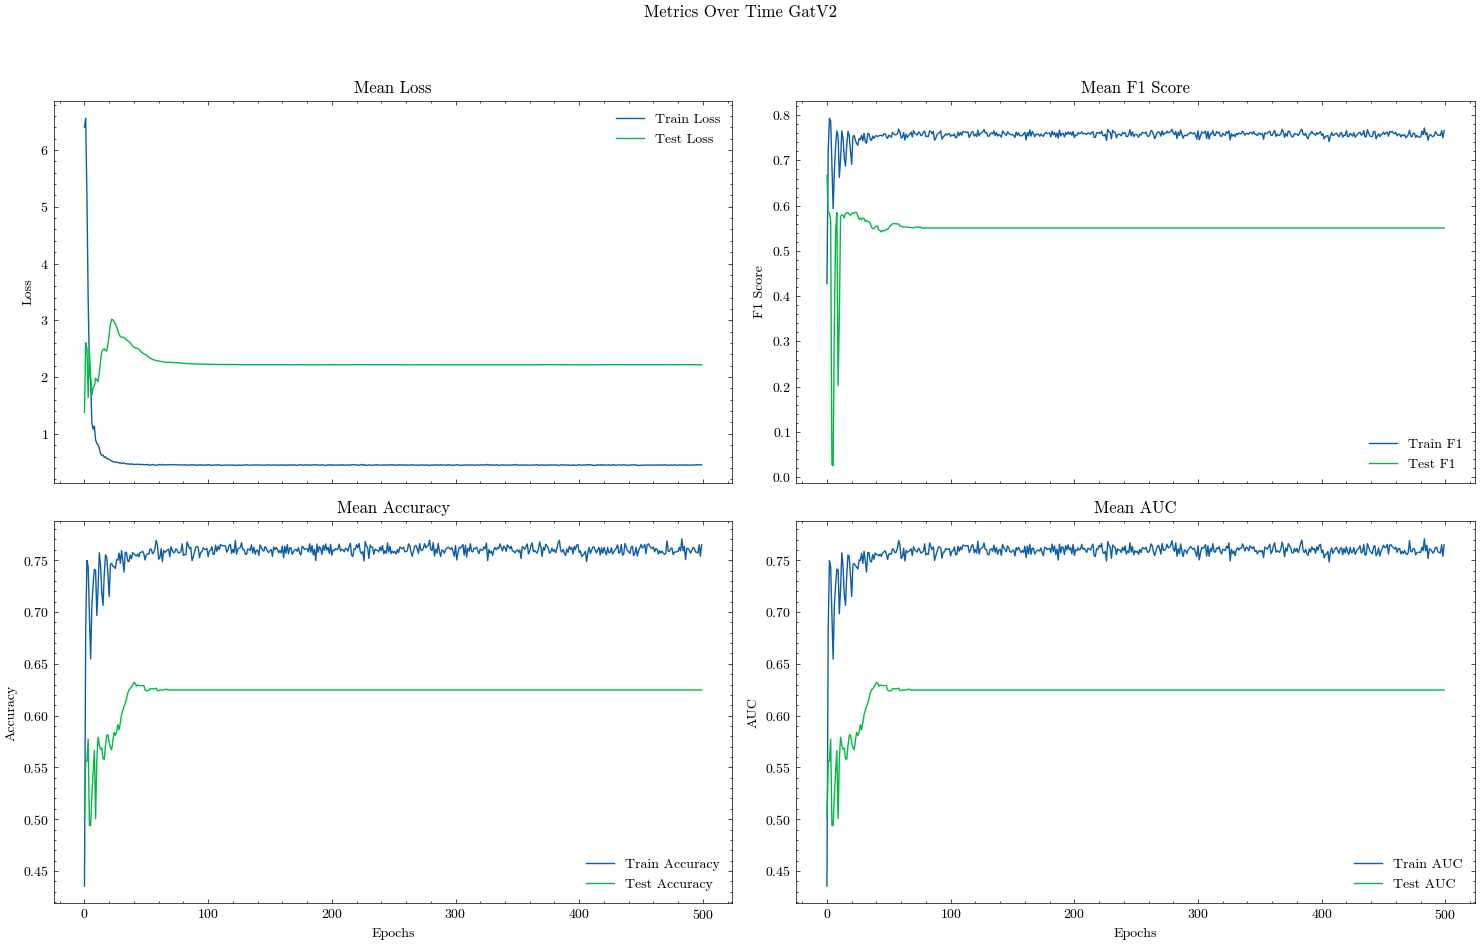

In [ ]:
plot_metrics_over_time(results_gatv2, 'Metrics Over Time GatV2')

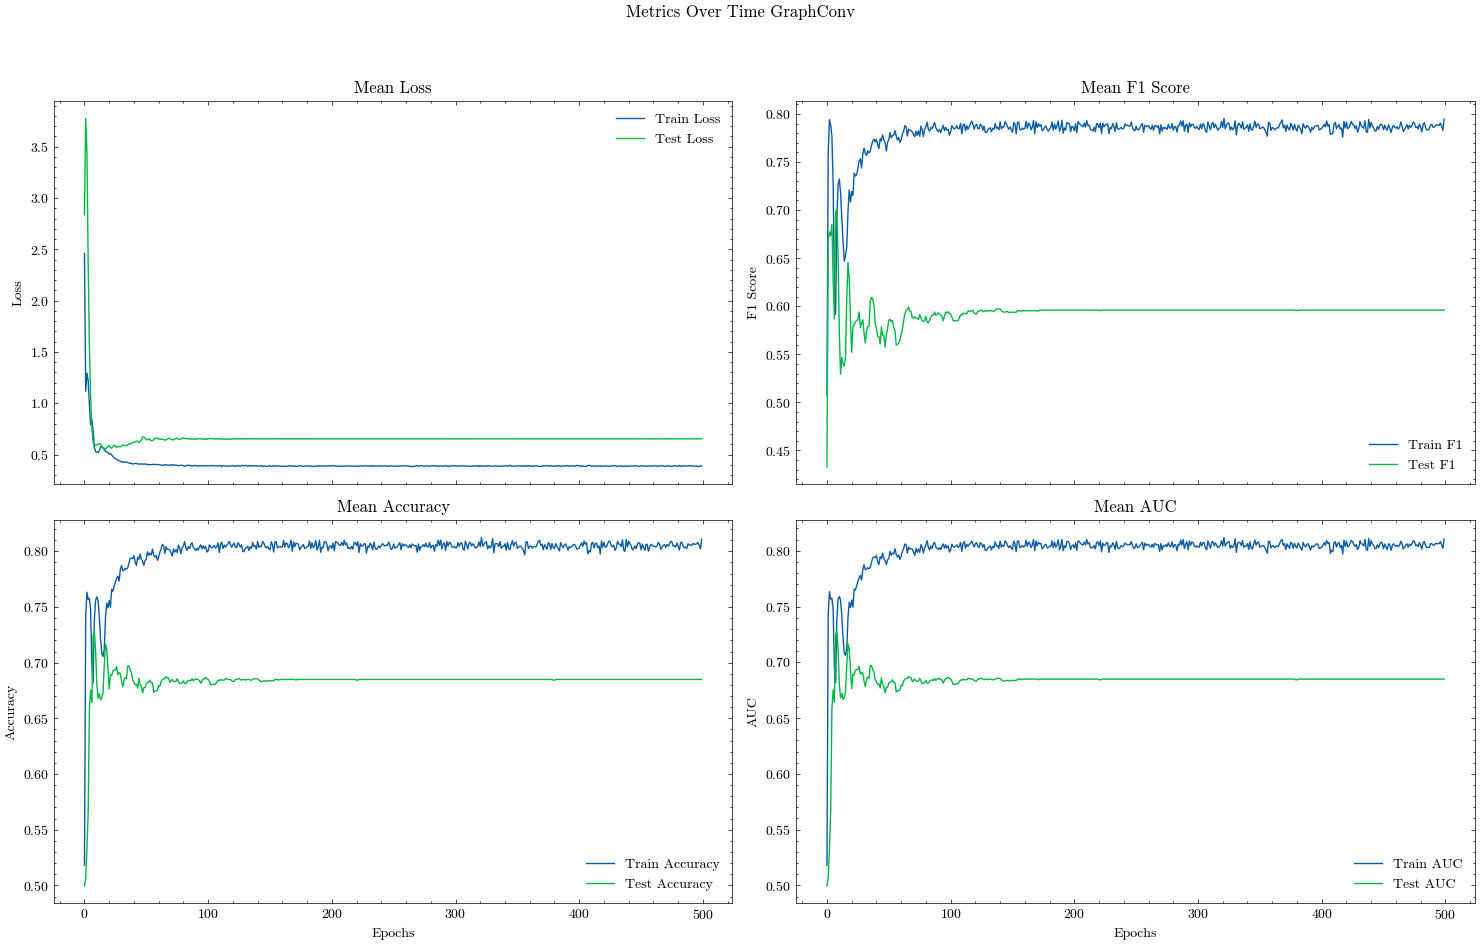

In [ ]:
plot_metrics_over_time(results_GraphConv, 'Metrics Over Time GraphConv')

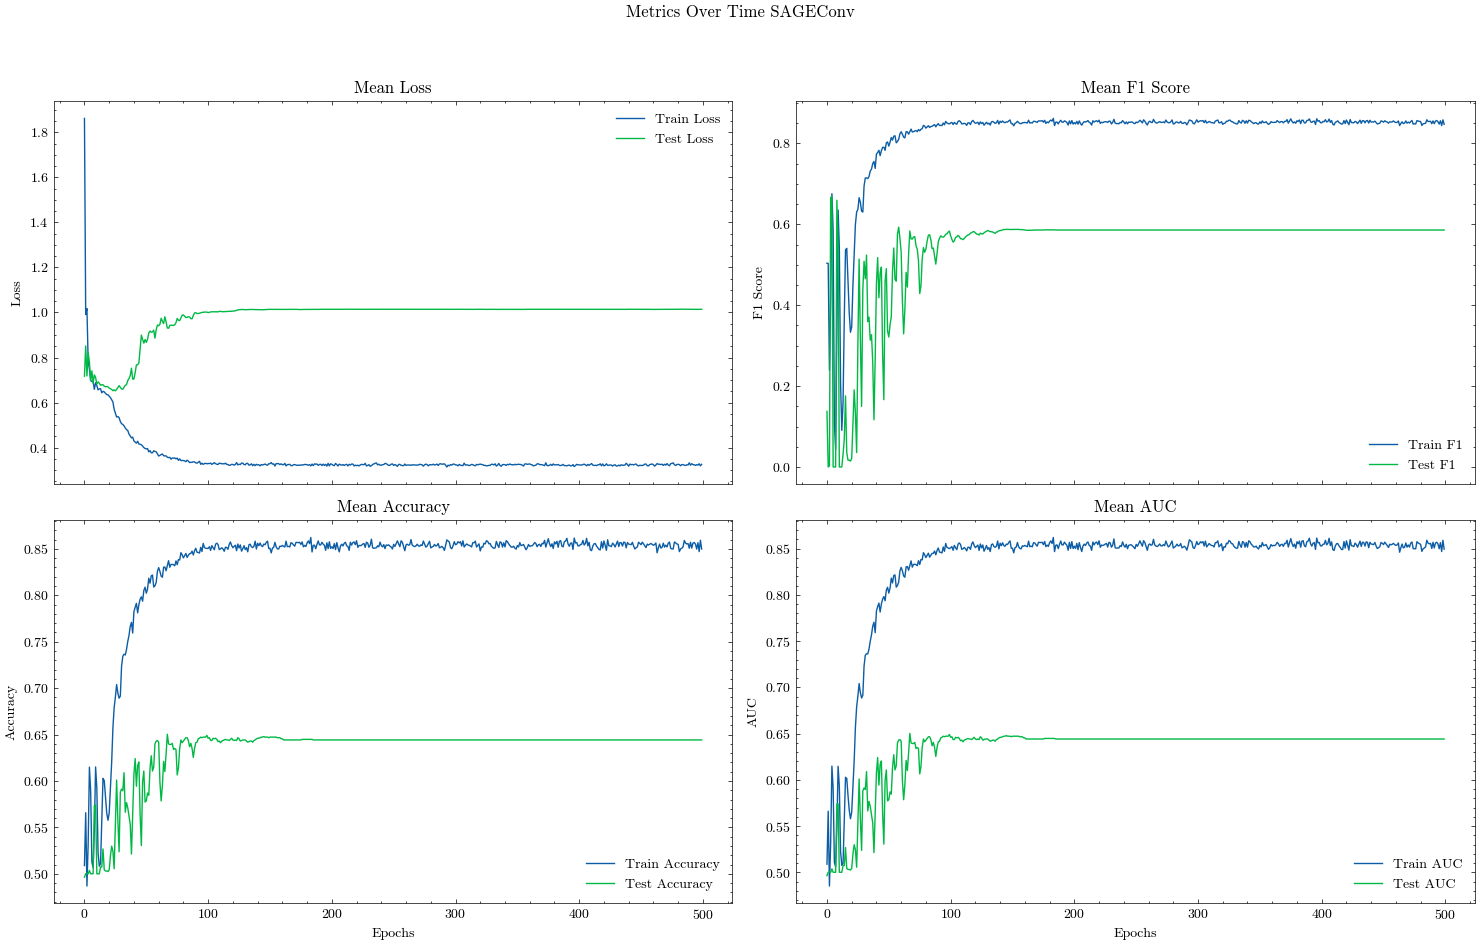

In [ ]:
plot_metrics_over_time(results_SAGEConv, 'Metrics Over Time SAGEConv')

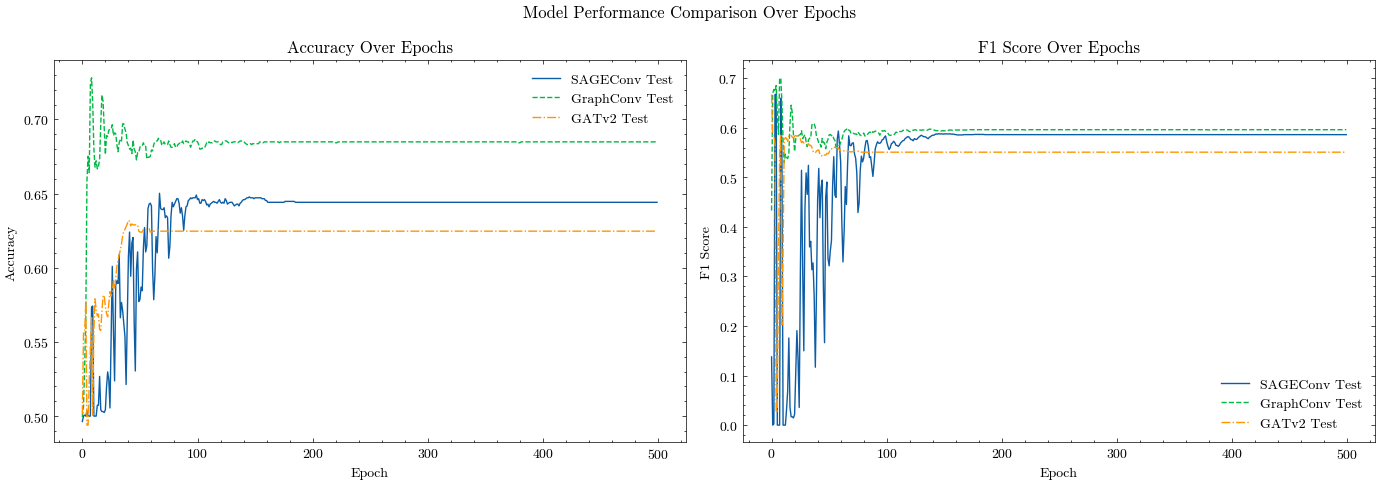

In [ ]:
# Assuming results_SAGEConv, results_GraphConv, results_gatv2 are dictionaries containing the required metrics
# Plotting function call example (you need to provide the actual dictionaries)

results_dict = {
     'SAGEConv': results_SAGEConv,
     'GraphConv': results_GraphConv,
     'GATv2': results_gatv2
 }

plot_accuracy_f1_over_epoch(results_dict, 'Model Performance Comparison Over Epochs')